In [23]:
try:
  from ajax import Prior, Likelihood, Variational, ADVI
except:
  %pip install -qq git+https://github.com/patel-zeel/ajax.git
  from ajax import Prior, Likelihood, Variational, ADVI

try:
  import optax
except:
  %pip install -qq optax
  import optax

try:
  import tensorflow_probability.substrates.jax as tfp
except:
  %pip install -qq tensorflow_probability.substrates.jax
  import tensorflow_probability.substrates.jax as tfp

try:
  import jax.numpy as jnp
except:
  %pip install -qq jax
  import jax.numpy as jnp

try:
    import seaborn as sns
except:
    %pip install -qq seaborn 
    import seaborn as sns
from ajax.utils import fill_params
import jax
import matplotlib.pyplot as plt
import pickle
tfd = tfp.distributions
tfb = tfp.bijectors

In [24]:
with open("../data/coin_toss",'rb') as f:
    data = pickle.load(f)
data

{'samples': array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1], dtype=int32),
 'prior': {'alpha': 10, 'beta': 15}}

In [25]:
dataset = data['samples']
prior_alpha = data['prior']['alpha']
prior_beta = data['prior']['beta']


In [26]:
prior = Prior(
    distributions = {
        "theta" : tfd.Weibull(concentration = prior_alpha, scale = prior_beta)
        }
    )

In [27]:
def link_function(samples):
    lamda = samples["theta"]
    return {"rate" : lamda}

In [28]:
likelihood = Likelihood(tfd.Poisson, link_function)
variational = Variational(
    prior=prior,
    bijectors={"theta":tfb.Softplus()},
    vi_type="full_rank"
)

In [29]:
advi = ADVI(prior, likelihood, variational, dataset)

In [30]:
params = variational.get_params()
tx = optax.adam(learning_rate=0.1)
state = tx.init(params)
value_and_grad_fun = jax.jit(jax.value_and_grad(advi.loss))

In [31]:
def update_func(carry,x):
  params = carry['params']
  state = carry['state']
  seed = carry['seed']
  seed = jax.random.split(seed, 1)[0]
  loss, grads = value_and_grad_fun(params, seed = seed)
  updates, state = tx.update(grads, state)
  params = optax.apply_updates(params, updates)
  carry = {'params':params, 'state':state, 'seed':seed}
  return carry, loss

In [32]:
carry = {'params':params, 'state': state,'seed':jax.random.PRNGKey(10)}
carry,loss = jax.lax.scan(update_func, carry,xs = None,length= 1000) 
variational.set_params(carry['params'])

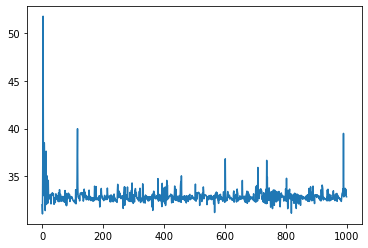

In [33]:
plt.plot(loss)

In [34]:
x = jnp.linspace(0,20,50000)
x = x.reshape(-1,1)
di = {"theta":x}
posterior_pdf = jnp.exp(variational.log_prob(di))

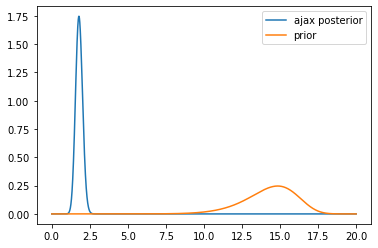

In [35]:
prior = tfd.Weibull(concentration = 10, scale = 15)
plt.plot(x,posterior_pdf,label = "ajax posterior")
plt.plot(x, prior.prob(x),label = "prior")
plt.legend()
plt.savefig("weibull")

In [36]:
with open("./weibull_Ajax",'wb') as f:
    pickle.dump(variational, f,protocol = 1)